In [1]:
import zipfile
import numpy as np
import io
import scipy.io.wavfile
import soundfile as sf
import os
import matplotlib.pyplot as plt
from bitstring import Array
from scipy.fft import fft, ifft, fftfreq
from scipy.fft import dct, idct

In [28]:
# read wavs from data.zip and print the amplitude range (min, max)
overall_min = np.inf
overall_max = -np.inf
max_range = 0
ranges = []
with zipfile.ZipFile('data.zip') as archive:
    for name in archive.namelist():
        if name.endswith('.wav'):
            with archive.open(name) as file:
                wav = scipy.io.wavfile.read(io.BytesIO(file.read()))
                min_val, max_val = np.min(wav[1]), np.max(wav[1])
                overall_min = min(overall_min, min_val)
                overall_max = max(overall_max, max_val)
                ranges.append(int(max_val) - int(min_val))
                max_range = max(max_range, int(max_val) - int(min_val))
print(overall_min, overall_max, max_range)

-32768 32767 65535


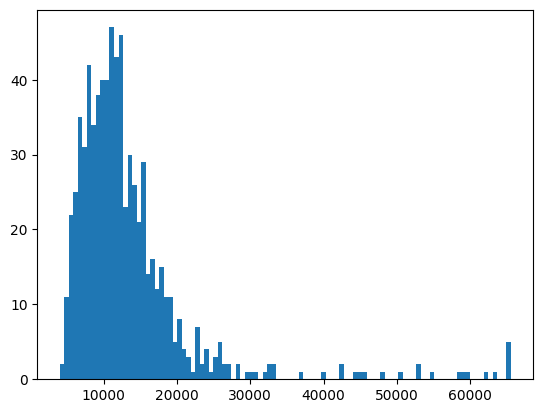

In [29]:
# plot histogram of the amplitude ranges
plt.hist(ranges, bins=100)
plt.show()

In [35]:
# approx compression ratio if only the necessary bits are used:
16 / np.mean(np.log2(ranges))

1.182677622748747

In [36]:
# storing deltas instead of absolute values
overall_min = np.inf
overall_max = -np.inf
max_range = 0
ranges = []
with zipfile.ZipFile('data.zip') as archive:
    for name in archive.namelist():
        if name.endswith('.wav'):
            with archive.open(name) as file:
                wav = scipy.io.wavfile.read(io.BytesIO(file.read()))
                deltas = np.diff(wav[1], 1)
                min_val, max_val = np.min(deltas), np.max(deltas)
                overall_min = min(overall_min, min_val)
                overall_max = max(overall_max, max_val)
                ranges.append(int(max_val) - int(min_val))
                max_range = max(max_range, int(max_val) - int(min_val))
print(overall_min, overall_max, max_range)

-21652 31391 44200


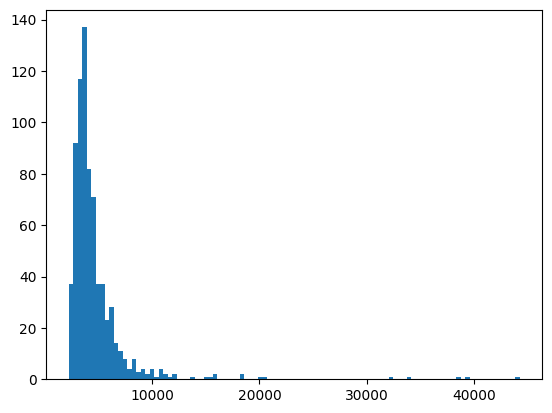

In [37]:
# plot histogram of the amplitude ranges
plt.hist(ranges, bins=100)
plt.show()

In [38]:
# approx compression ratio if only the necessary bits are used:
16 / np.mean(np.log2(ranges))

1.3283112675837416

In [55]:
a = 2**16-1
n = int(np.ceil(np.log2(a) / 8))
b = a.to_bytes(n + 1, byteorder='big', signed=True)
i = int.from_bytes(b, byteorder='big', signed=True)
print(a, n, b, i)

65535 2 b'\x00\xff\xff' 65535


In [17]:
# storing deltas instead of absolute values and then zipping
size = 0
zip_size = 0
with zipfile.ZipFile('data.zip') as archive:
    for name in archive.namelist():
        if name.endswith('.wav'):
            with archive.open(name) as file:
                wav = scipy.io.wavfile.read(io.BytesIO(file.read()))
                deltas = np.diff(wav[1], 1).astype(np.int32)
                min_val, max_val = int(np.min(deltas)), int(np.max(deltas))
                deltas -= min_val
                amplitude = max_val - min_val
                necessary_bits = int(np.ceil(np.log2(amplitude)))
                # zip deltas
                with zipfile.ZipFile('deltas.zip', 'a') as out_archive:
                    with io.BytesIO() as out_file:
                        # write min as the first 2 bytes
                        out_file.write(min_val.to_bytes(2, byteorder='big', signed=True))
                        out_file.write(necessary_bits.to_bytes(1, byteorder='big'))
                        out_file.write(Array('uint'+str(necessary_bits), deltas).data.tobytes())
                        out_archive.writestr(name, out_file.getvalue())
                        size += len(out_file.getvalue())
                    zip_size += out_archive.getinfo(name).compress_size
                os.remove('deltas.zip')
print(size, zip_size)

114842948 114842948


In [18]:
# compression ratios
print(146800526 / size, 146800526 / zip_size)

1.2782720102239102 1.2782720102239102


In [7]:
# compare zipped size with unzipped size
zipped_size = 0
unzipped_size = 0
with zipfile.ZipFile('data.zip') as archive:
    for name in archive.namelist():
        zipped_size += archive.getinfo(name).compress_size
        unzipped_size += archive.getinfo(name).file_size
print(zipped_size, unzipped_size, unzipped_size / zipped_size)

65252477 146800526 2.2497310868367495


In [110]:
# compare size with flac audio format using soundfile sf
wav_size = 0
flac_size = 0
with zipfile.ZipFile('data.zip') as archive:
    for name in archive.namelist():
        if name.endswith('.wav'):
            with archive.open(name) as file:
                wav = scipy.io.wavfile.read(io.BytesIO(file.read()))
                with io.BytesIO() as wav_file:
                    sf.write(wav_file, wav[1], wav[0], format='wav')
                    wav_size += len(wav_file.getvalue())
                with io.BytesIO() as flac_file:
                    sf.write(flac_file, wav[1], wav[0], format='flac')
                    flac_size += len(flac_file.getvalue())
print(wav_size, flac_size)

146800526 98575029


In [111]:
# print flac compression ratio
print(wav_size / flac_size)

1.4892263029412856


In [112]:
# flac + zip size
flac_zip_size = 0
with zipfile.ZipFile('data.zip') as archive:
    for name in archive.namelist():
        if name.endswith('.wav'):
            with archive.open(name) as file:
                wav = scipy.io.wavfile.read(io.BytesIO(file.read()))
                with io.BytesIO() as flac_file:
                    sf.write(flac_file, wav[1], wav[0], format='flac')
                    with zipfile.ZipFile('flac.zip', 'w') as flac_archive:
                        flac_archive.writestr(name, flac_file.getvalue())
                    flac_zip_size += flac_archive.getinfo(name).compress_size
                    os.remove('flac.zip')
print(flac_zip_size, wav_size / flac_zip_size)


98575029 1.4892263029412856


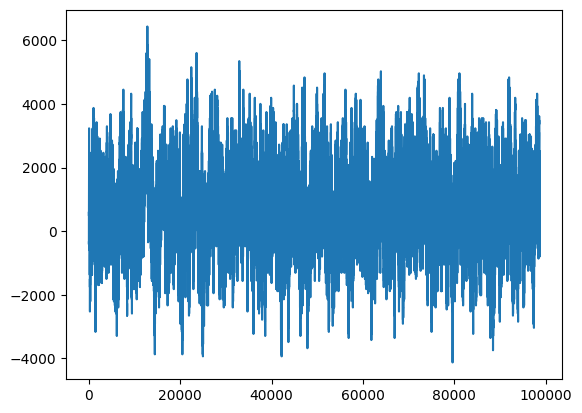

In [32]:
# plot a sample wav file over time
with zipfile.ZipFile('data.zip') as archive:
    with archive.open(archive.namelist()[1]) as file:
            wav = scipy.io.wavfile.read(io.BytesIO(file.read()))
            plt.plot(wav[1])
            plt.show()

In [ ]:
# Find the best lossy compression and make it exact

98699 98699
0
6.4110601599123444e-12
0.5266821345707656


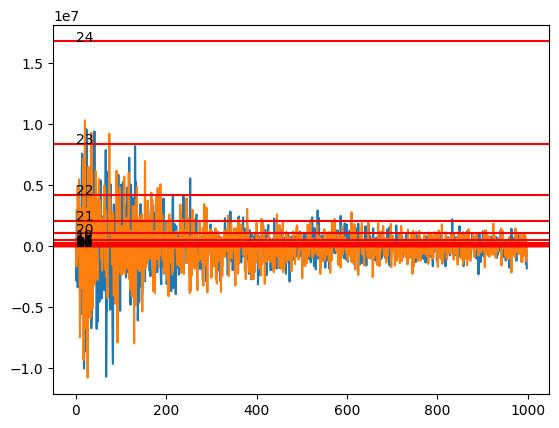

In [452]:
# plot the fft of the sample wav file
with zipfile.ZipFile('data.zip') as archive:
    with archive.open(archive.namelist()[1]) as file:
            wav = scipy.io.wavfile.read(io.BytesIO(file.read()))[1]
            y = fft(wav)
            print(len(wav), len(y))
            R = int(len(y) * 0.00001)
            print(2 * R)
            y[len(y)//2-R:len(y)//2+R] = 0
            print(np.max(np.abs(ifft(y) - wav)))
            print(sum((ifft(y).real.astype(np.int16) - wav) == 0) / len(wav))
            y = y[1:1000]
            plt.plot(y.real)
            plt.plot(y.imag)
            # horizontal lines at powers of 2
            for i in range(2, np.log2(np.abs(np.max(y.real))).astype(int) + 2):
                plt.axhline(2**i, color='r')
                plt.text(0, 2**i, str(i))
            plt.show()

In [134]:
bits = 0
wavsize = 0
with zipfile.ZipFile('data.zip') as archive:
    for name in archive.namelist()[1:2]:
        if not name.endswith('.wav'):
            continue
        with archive.open(name) as file:
            wav = scipy.io.wavfile.read(io.BytesIO(file.read()))[1]
            y = fft(wav)
            R = int(len(y) * 0.0001)
            print(2 * R)
            y[len(y)//2-R:len(y)//2+R] = 0
            print(np.max(np.abs(ifft(y) - wav)))
            y = y.astype(np.complex64).view(np.float32).astype(np.int32)

            deltas = np.diff(y, 1)
            min_val, max_val = int(np.min(deltas)), int(np.max(deltas))
            amplitude = max_val - min_val
            fft_bits = int(np.ceil(np.log2(amplitude))) if amplitude > 0 else 0
            print(fft_bits)

            y = y.astype(np.float32).view(np.complex64)
            v = ifft(y).astype(np.int16)
            deltas = v - wav
            print(sum(deltas != 0) / len(deltas))
            min_val, max_val = int(np.min(deltas)), int(np.max(deltas))
            # deltas -= min_val
            amplitude = max_val - min_val
            necessary_bits = int(np.ceil(np.log2(amplitude))) if amplitude > 0 else 0
            print(necessary_bits)
            bits += 48 + necessary_bits * sum(deltas != 0) + 2 * fft_bits * (len(y) - 2 * R)
            wavsize += len(wav) * 16
byts = int(np.ceil(bits / 8))
wavsize = int(np.ceil(wavsize / 8))
print(byts, wavsize / byts)

18
5.292517748768002
54
0.8627037761274177
4
708677 0.2785443862295517


/var/folders/gz/pp4ldsnj0tjbngm2gygkp8qc0000gn/T/ipykernel_7849/3434613852.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  v = ifft(y).astype(np.int16)


In [237]:
bits = 0
wavsize = 0
R = 98699
with zipfile.ZipFile('data.zip') as archive:
    for name in archive.namelist():
        if not name.endswith('.wav'):
            continue
        with archive.open(name) as file:
            wav = scipy.io.wavfile.read(io.BytesIO(file.read()))[1]
            y = np.array(dct(wav), dtype=np.complex64)
            y[np.abs(y).argsort()[:R]] = 0
            v = np.array(idct(y), dtype=np.int8)
            print(np.max(np.abs(idct(y) - wav)))
            print(np.max(np.abs(v)))
            deltas = np.diff(v - wav, 1)
            min_val, max_val = int(np.min(deltas)), int(np.max(deltas))
            deltas -= min_val
            amplitude = max_val - min_val
            necessary_bits = int(np.ceil(np.log2(amplitude))) if amplitude > 0 else 0
            bits += 16 + 8 + necessary_bits * len(deltas) + 8 * (len(y) - R)
            wavsize += len(wav) * 16
        break
byts = int(np.ceil(bits / 8))
wavsize = int(np.ceil(wavsize / 8))
print(byts, wavsize / byts)

6437.0
0
148050 1.3333198243836542


/var/folders/gz/pp4ldsnj0tjbngm2gygkp8qc0000gn/T/ipykernel_99224/3484409385.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  v = np.array(idct(y), dtype=np.int8)


In [244]:
bits = 0
wavsize = 0
R1 = 98699
R2 = 98699
with zipfile.ZipFile('data.zip') as archive:
    for name in archive.namelist():
        if not name.endswith('.wav'):
            continue
        with archive.open(name) as file:
            wav = scipy.io.wavfile.read(io.BytesIO(file.read()))[1]
            y = np.array(dct(wav), dtype=np.complex64)
            y[np.abs(y).argsort()[:R1]] = 0
            v = np.array(idct(y), dtype=np.int8) - wav
            print(np.max(np.abs(v)))
            y = np.array(fft(v), dtype=np.complex64)
            y[fftfreq(len(y), 1 / 800)[:R2].astype(int)] = 0
            v = np.array(ifft(y), dtype=np.int8) - v
            print(np.max(np.abs(v)))
            deltas = np.diff(v, 1)
            min_val, max_val = int(np.min(deltas)), int(np.max(deltas))
            deltas -= min_val
            amplitude = max_val - min_val
            necessary_bits = int(np.ceil(np.log2(amplitude))) if amplitude > 0 else 0
            bits += 16 + 8 + necessary_bits * len(deltas) + 8 * (len(y) - R1) + 8 * (len(y) - R2)
            wavsize += len(wav) * 16
        break
byts = int(np.ceil(bits / 8))
wavsize = int(np.ceil(wavsize / 8))
print(byts, wavsize / byts)

6437
6509
148050 1.3333198243836542


/var/folders/gz/pp4ldsnj0tjbngm2gygkp8qc0000gn/T/ipykernel_99224/3262839259.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  v = np.array(idct(y), dtype=np.int8) - wav
/var/folders/gz/pp4ldsnj0tjbngm2gygkp8qc0000gn/T/ipykernel_99224/3262839259.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  v = np.array(ifft(y), dtype=np.int8) - v


In [136]:
import pywt

In [144]:
pywt.wavelist()

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'haar',
 'mexh',
 'morl',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',

In [262]:
def necessary_bits(data, diff=True):
    deltas = np.diff(data, 1) if diff else data
    min_val, max_val = int(np.min(deltas)), int(np.max(deltas))
    amplitude = max_val - min_val
    return int(np.ceil(np.log2(amplitude))) + 1 if amplitude > 0 else 0

14 13
Max Diff: 2
Perfect Match Ratio: 0.26218097447795824
Delta Bits: 3
193871 1.0181925094521616


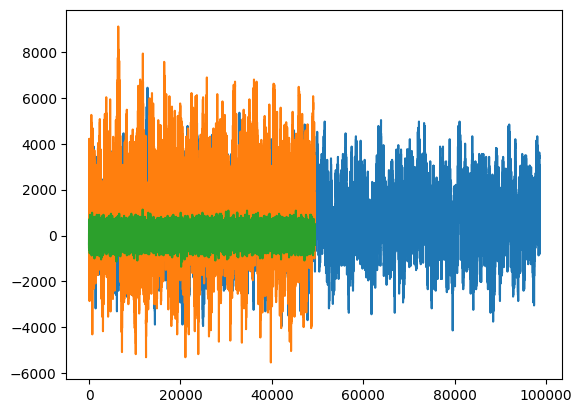

In [261]:
bits = 0
wavsize = 0
wavelet = "db1"
with zipfile.ZipFile('data.zip') as archive:
    for name in archive.namelist()[1:2]:
        if not name.endswith('.wav'):
            continue
        with archive.open(name) as file:
            wav = scipy.io.wavfile.read(io.BytesIO(file.read()))[1]
            plt.plot(wav)
            
            cA, cD = pywt.dwt(wav, wavelet)
            cA = cA.astype(np.int16)
            cD = cD.astype(np.int16)
            plt.plot(cA)
            plt.plot(cD)
            # R = sum(np.abs(cA) < 30)# int(len(cA) * 0.0001)
            # print(R)
            # cA[np.abs(cA).argsort()[:R]] = 0
            # cD[np.abs(cD).argsort()[:R]] = 0
            ncA = necessary_bits(cA.view(np.int16))
            ncD = necessary_bits(cD.view(np.int16))
            print(ncA, ncD)

            v = pywt.idwt(cA, cD, wavelet)[:-1].astype(np.int16)
            print("Max Diff:", np.max(np.abs(v - wav)))
            print("Perfect Match Ratio:", sum(v == wav) / len(wav))
            deltas = (v - wav)[v != wav]
            nD = necessary_bits(deltas, False)
            print("Delta Bits:", nD)

            bits += 48 + nD * len(deltas) + ncA * (len(cA) - R) + ncD * (len(cD) - R)
            wavsize += len(wav) * 16
byts = int(np.ceil(bits / 8))
wavsize = int(np.ceil(wavsize / 8))
print(byts, wavsize / byts)

In [344]:
bits = 0
wavsize = 0
with zipfile.ZipFile('data.zip') as archive:
    for name in archive.namelist()[1:2]:
        if not name.endswith('.wav'):
            continue
        with archive.open(name) as file:
            wav = scipy.io.wavfile.read(io.BytesIO(file.read()))[1]
            y = fft(wav)
            fft_bits = 0
            parts = []
            prev = 0
            for S, T in [(1, np.int32), (150, np.int32), (300, np.int32), (1011, np.int32), (len(y) - 2, np.int32), (len(y), np.int32)]:
            # for S, T in [(i, np.int32) for i in range(1, len(y) + 1, 10)]:
                y_section = y[prev:S].astype(np.complex64).view(np.float32).astype(T)
                prev = S
                fft_bits += necessary_bits(y_section) * len(y_section) + 64
                print(S, necessary_bits(y_section))
                parts += [y_section.astype(np.float32).view(np.complex64)]
            y = np.concatenate(parts)
            print(np.max(np.abs(ifft(y) - wav)))


            v = ifft(y).real.astype(np.int16)
            deltas = v - wav
            print(sum(deltas == 0) / len(deltas))
            print(necessary_bits(deltas))
            delta_bits = necessary_bits(deltas) * sum(deltas != 0)
            bits += 48 + delta_bits + fft_bits
            wavsize += len(wav) * 16
byts = int(np.ceil(bits / 8))
wavsize = int(np.ceil(wavsize / 8))
print(byts, wavsize / byts)

1 0
150 27
300 26
1011 25
98697 26
98699 24
0.01135319
0.40941650877921765
3
663309 0.29759584145549056


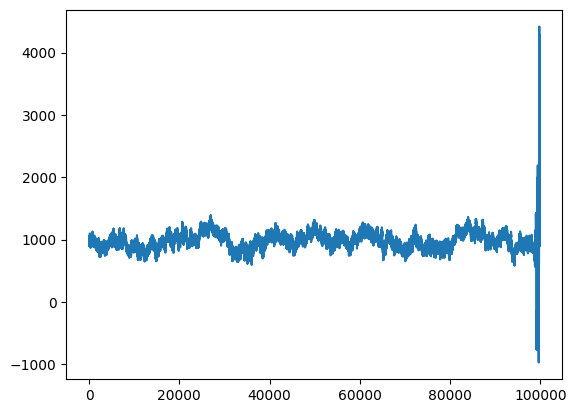

In [345]:
average_wav = []
counts = []
with zipfile.ZipFile('data.zip') as archive:
    for name in archive.namelist():
        if not name.endswith('.wav'):
            continue
        with archive.open(name) as file:
            wav = scipy.io.wavfile.read(io.BytesIO(file.read()))[1]
            for i in range(len(wav)):
                if i >= len(average_wav):
                    counts.append(0)
                    average_wav.append(0)
                average_wav[i] += wav[i]
                counts[i] += 1

average_wav = np.array(average_wav) / np.array(counts)
plt.plot(average_wav)
plt.show()           


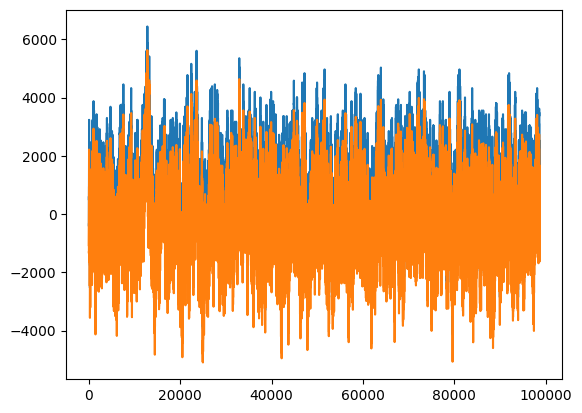

In [348]:
with zipfile.ZipFile('data.zip') as archive:
    for name in archive.namelist()[1:2]:
        if not name.endswith('.wav'):
            continue
        with archive.open(name) as file:
            wav = scipy.io.wavfile.read(io.BytesIO(file.read()))[1]
            plt.plot(wav)
            plt.plot(wav - average_wav[:len(wav)])
            plt.show()

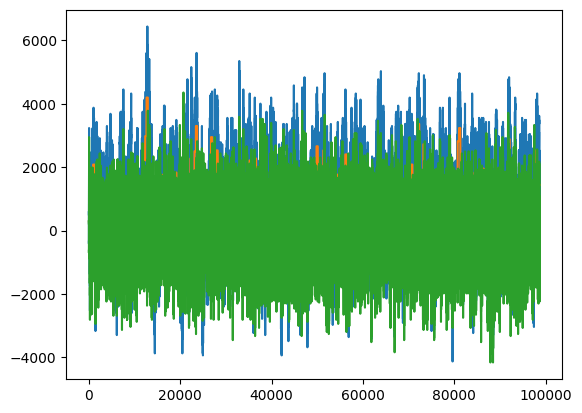

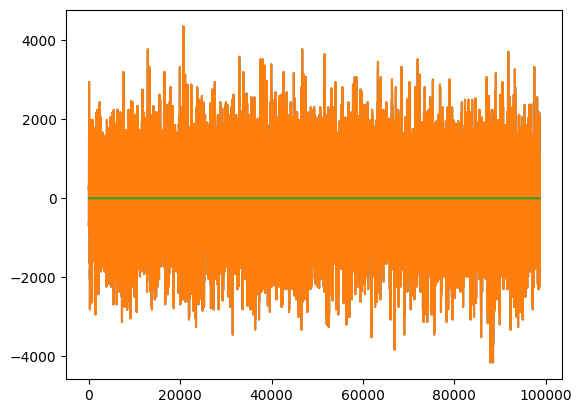

0
173303 1.1390339463252224


In [443]:
bits = 0
wavsize = 0

with zipfile.ZipFile('data.zip') as archive:
    for name in archive.namelist()[1:2]:
        if not name.endswith('.wav'):
            continue
        with archive.open(name) as file:
            wav = scipy.io.wavfile.read(io.BytesIO(file.read()))[1].copy()
            wavsize += len(wav) * 16

            for s in [300, 1]:
                w = np.ceil(len(wav) / s).astype(int)
                averages = np.zeros(w, dtype=np.int16)
                for i in range(w):
                    averages[i] = np.median(wav[i*s:(i+1)*s])
                bits += necessary_bits(averages) * len(averages) + 16
                reconstructed = np.repeat(averages, s)
                plt.plot(wav)
                plt.plot(reconstructed[:len(wav)])
                wav -= reconstructed[:len(wav)]
                plt.plot(wav)
                plt.show()

            print(np.max(np.abs(wav)))

byts = int(np.ceil(bits / 8))
wavsize = int(np.ceil(wavsize / 8))
print(byts, wavsize / byts)

In [454]:
bits = 0
wavsize = 0

with zipfile.ZipFile('data.zip') as archive:
    for name in archive.namelist():
        if not name.endswith('.wav'):
            continue
        with archive.open(name) as file:
            wav = scipy.io.wavfile.read(io.BytesIO(file.read()))[1].copy()
            wavsize += len(wav) * 16

            u = np.unique(wav)
            nu = len(np.unique(wav))
            bu = necessary_bits(np.unique(wav))
            bnu = np.log2(nu)
            # bits += nu * bu + bnu * len(wav)

            w = [list(u).index(x) for x in wav]
            bits += nu * bu + necessary_bits(w) * len(w)

byts = int(np.ceil(bits / 8))
wavsize = int(np.ceil(wavsize / 8))
print(byts, wavsize / byts)

68711952 2.135986967740343


In [457]:
print(len(set(scipy.io.wavfile.read('./test.wav')[1])))

126


1016


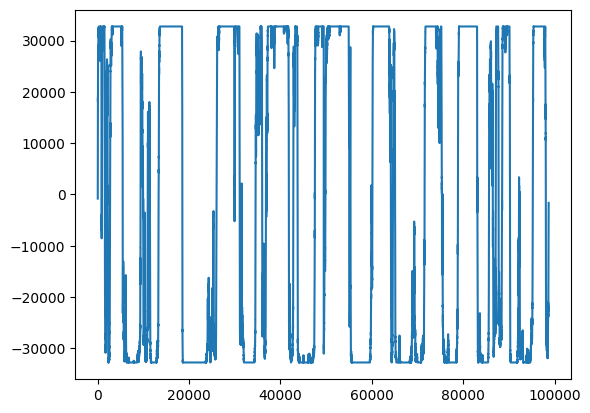

In [459]:
# inspect data/4fdc6242-e58b-4687-bd69-94e4aa83db0f.wav
with zipfile.ZipFile('data.zip') as archive:
    for name in archive.namelist():
        if name.endswith('4fdc6242-e58b-4687-bd69-94e4aa83db0f.wav'):
            with archive.open(name) as file:
                wav = scipy.io.wavfile.read(io.BytesIO(file.read()))[1]
                # print number of unique values
                print(len(set(wav)))
                plt.plot(wav)
                plt.show()

In [461]:
bits = 0
wavsize = 0

with zipfile.ZipFile('data.zip') as archive:
    for name in archive.namelist():
        if name.endswith('4fdc6242-e58b-4687-bd69-94e4aa83db0f.wav'):
            with archive.open(name) as file:
                wav = scipy.io.wavfile.read(io.BytesIO(file.read()))[1].copy()
                wavsize += len(wav) * 16

                u = np.unique(wav)
                nu = len(np.unique(wav))
                bu = necessary_bits(np.unique(wav))
                bnu = np.log2(nu)
                # bits += nu * bu + bnu * len(wav)

                w = [list(u).index(x) for x in wav]
                bits += nu * bu + necessary_bits(w) * len(w)

byts = int(np.ceil(bits / 8))
wavsize = int(np.ceil(wavsize / 8))
print(byts, wavsize / byts)

136763 1.443738438027829


In [460]:
# print max unique values
max_unique = 0
with zipfile.ZipFile('data.zip') as archive:
    for name in archive.namelist():
        if name.endswith('.wav'):
            with archive.open(name) as file:
                wav = scipy.io.wavfile.read(io.BytesIO(file.read()))[1]
                max_unique = max(max_unique, len(set(wav)))
print(max_unique)

1019


## tANS
https://github.com/GarethCa/Py-tANS/blob/master/Py-tANS.ipynb

In [1]:
from collections import Counter
from math import floor, ceil
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Return the Index of the First Non-Zero Bit.
def first1Index(val):
    counter = 0
    while val > 1:
        counter += 1
        val = val >> 1
    return counter

In [3]:
tableLog = 5
tableSize = 1 << tableLog
# Define how often a symbol is seen, total should equal the 
# table size.
symbol_occurrences = {"0":10,"1":10, "2":12}

In [4]:
####
# Define the Initial Positions of States in StateList.
####
symbol_list = [symbol for symbol,occcurences in symbol_occurrences.items()]
cumulative = [0 for _ in range(len(symbol_list)+2)]
for u in range(1, len(symbol_occurrences.items())+ 1):
    cumulative[u] = cumulative[u - 1] + list(symbol_occurrences.items())[u-1][1]
cumulative[-1] = tableSize +1

In [5]:
#####
# Spread Symbols to Create the States Table
#####
highThresh = tableSize - 1
stateTable = [0 for _ in range(tableSize)]
tableMask = tableSize - 1
step = ((tableSize >> 1) + (tableSize >> 3) + 3)
pos = 0
for symbol, occurrences in symbol_occurrences.items():
    for i in range(occurrences):
        stateTable[pos] = symbol
        pos = (pos + step) & tableMask
        while pos > highThresh:
            position = (pos + step) & tableMask
assert(pos == 0)
print(stateTable)

['0', '0', '1', '2', '2', '0', '1', '1', '2', '2', '0', '1', '2', '2', '0', '0', '1', '2', '2', '0', '1', '1', '2', '0', '0', '1', '2', '2', '0', '1', '1', '2']


In [6]:
#####
# Build Coding Table from State Table
#####
outputBits = [0 for _ in range(tableSize)]
codingTable = [0 for _ in range(tableSize)]
cumulative_cp = cumulative.copy()
for i in range(tableSize):
    s = stateTable[i]
    index = symbol_list.index(s)
    codingTable[cumulative_cp[index]] = tableSize + i
    cumulative_cp[index] += 1
    outputBits[i] = tableLog - first1Index(tableSize + i)

In [7]:
#####
# Create the Symbol Transformation Table
#####
total = 0
symbolTT = {}
for symbol, occurrences in symbol_occurrences.items():
    symbolTT[symbol] = {}
    if occurrences == 1:
        symbolTT[symbol]['deltaNbBits'] = (tableLog << 16) - (1 << tableLog)
        symbolTT[symbol]['deltaFindState'] = total - 1
    elif occurrences > 0:
        maxBitsOut = tableLog - first1Index(occurrences - 1)
        minStatePlus = occurrences << maxBitsOut
        symbolTT[symbol]['deltaNbBits'] = (maxBitsOut << 16) - minStatePlus
        symbolTT[symbol]['deltaFindState'] = total - occurrences
        total += occurrences
print(symbolTT)

{'0': {'deltaNbBits': 131032, 'deltaFindState': -10}, '1': {'deltaNbBits': 131032, 'deltaFindState': 0}, '2': {'deltaNbBits': 131024, 'deltaFindState': 8}}


In [8]:
# Output NbBits to a BitStream
def outputNbBits(state, nbBits):
    mask = (1 << nbBits) -1
    little = state & mask
    if nbBits >0:
        string = "{:b}".format(little)
    else:
        return ""
    while len(string) < nbBits:
        string = "0" + string
    return string

In [58]:
# Encode a Symbol Using tANS, giving the current state, the symbol, and the bitstream and STT
def encodeSymbol(symbol, state, bitStream, symbolTT):
    symbolTT = symbolTT[symbol]
    nbBitsOut = (state + symbolTT['deltaNbBits']) >> 16
    bitStream += outputNbBits(state,nbBitsOut)
    state = codingTable[(state >> nbBitsOut) + symbolTT['deltaFindState']]
    return state, bitStream

In [10]:
#####
# Generate a Decoding Table
#####
decodeTable = [{} for _ in range(tableSize)]
nextt = list(symbol_occurrences.items())
for i in range(tableSize):
    t = {}
    t['symbol'] = stateTable[i]
    index = symbol_list.index(t['symbol'])
    x = nextt[index][1]
    nextt[index] = (nextt[index][0], nextt[index][1] + 1)
    t['nbBits'] = tableLog - first1Index(x)
    t['newX'] = (x << t['nbBits']) - tableSize
    decodeTable[i] = t

In [11]:
# Convert Bits from Bitstream to the new State.
def bitsToState(bitStream, nbBits):
    bits = bitStream[-nbBits:]
    rest = int(bits,2)
    if nbBits == len(bitStream):
        remaining = ""
        return rest, remaining
    remaining = bitStream[:-nbBits]
    return rest, remaining

In [12]:
# Return a Symbol + New State + Bitstream from the bitStream and State.
def decodeSymbol(state, bitStream, stateT):
    symbol = stateT[state]['symbol']
    nbBits = stateT[state]['nbBits']
    rest, bitStream = bitsToState(bitStream, nbBits)
    state = stateT[state]['newX'] + rest
    return symbol, state, bitStream

In [13]:
# Split an Input String into a list of Symbols
def split(string):
    return [char for char in string]

In [14]:
#####
# Functions to Encode and Decode Streams of Data.
#####
def encodeData(inpu):
    bitStream = ""
    state, bitStream = encodeSymbol(inpu[0], 0, "", symbolTT)
    bitStream = ""
    for char in inpu:
        state, bitStream = encodeSymbol(char, state, bitStream, symbolTT)
    bitStream += outputNbBits(state - tableSize, tableLog) #Includes Current Bit
    return bitStream

def decodeData(bitStream):
    output = []
    state, bitStream = bitsToState(bitStream, tableLog)
    while len(bitStream) > 0:
        symbol, state, bitStream = decodeSymbol(state, bitStream, decodeTable)
        output = [symbol] + output
    return output

In [15]:
# Test Encoding
inpu = "1102010120"
bitStream = encodeData(inpu)

In [16]:
# Test Decoding
output = decodeData(bitStream)

In [17]:
# Assert that input and Output are the same
print(split(inpu), " = input")
print(bitStream, " = bitStream")
print(output, " = output")
assert(split(inpu) == output)

['1', '1', '0', '2', '0', '1', '0', '1', '2', '0']  = input
001110001011000100001  = bitStream
['1', '1', '0', '2', '0', '1', '0', '1', '2', '0']  = output


1024 1024


ValueError: operands could not be broadcast together with shapes (98699,) (98003,) 

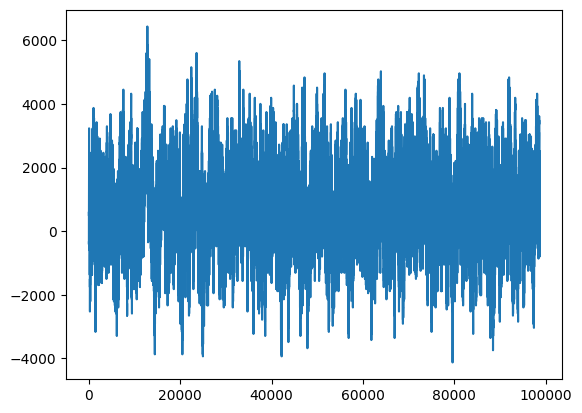

In [64]:
wavsize = 0
compressed_size = 0
with zipfile.ZipFile('data.zip') as archive:
    for name in archive.namelist()[1:2]:
        if not name.endswith('.wav'):
            continue
        with archive.open(name) as file:
            wav = scipy.io.wavfile.read(io.BytesIO(file.read()))[1]
            wavsize += len(wav) * 16

            tableLog = 10
            tableSize = 1 << tableLog
            symbol_occurrences = dict(Counter(wav))
            # scale up occurence counts to sum to table size
            scale = tableSize / sum(symbol_occurrences.values())
            symbol_occurrences = {k: int(v * scale) for k, v in symbol_occurrences.items()}
            # subtract the difference
            for k, v in symbol_occurrences.items():
                if symbol_occurrences[k] < 1:
                    symbol_occurrences[k] = 1
            diff = tableSize - sum(symbol_occurrences.values())
            sign_diff = 1 if diff > 0 else -1
            while diff != 0:
                for k, v in symbol_occurrences.items():
                    if diff == 0:
                        break
                    if symbol_occurrences[k] > 0:
                        symbol_occurrences[k] += sign_diff
                        diff -= sign_diff
            print(tableSize, sum(symbol_occurrences.values()))

            symbol_list = [symbol for symbol,occurrences in symbol_occurrences.items()]
            cumulative = [0 for _ in range(len(symbol_list)+2)]
            for u in range(1, len(symbol_occurrences.items())+ 1):
                cumulative[u] = cumulative[u - 1] + list(symbol_occurrences.items())[u-1][1]
            cumulative[-1] = tableSize +1

            highThresh = tableSize - 1
            stateTable = np.zeros(tableSize, dtype=np.int32)
            tableMask = tableSize - 1
            step = ((tableSize >> 1) + (tableSize >> 3) + 3)
            pos = 0
            for symbol, occurrences in symbol_occurrences.items():
                for i in range(occurrences):
                    stateTable[pos] = symbol
                    pos = (pos + step) & tableMask
                    while pos > highThresh:
                        position = (pos + step) & tableMask
            assert pos == 0, pos

            outputBits = [0 for _ in range(tableSize)]
            codingTable = [0 for _ in range(tableSize)]
            cumulative_cp = cumulative.copy()
            for i in range(tableSize):
                s = stateTable[i]
                index = symbol_list.index(s)
                codingTable[cumulative_cp[index]] = tableSize + i
                cumulative_cp[index] += 1
                outputBits[i] = tableLog - first1Index(tableSize + i)

            total = 0
            symbolTT = {}
            for symbol, occurrences in symbol_occurrences.items():
                symbolTT[symbol] = {}
                if occurrences == 1:
                    symbolTT[symbol]['deltaNbBits'] = (tableLog << 16) - (1 << tableLog)
                    symbolTT[symbol]['deltaFindState'] = total - 1
                elif occurrences > 0:
                    maxBitsOut = tableLog - first1Index(occurrences - 1)
                    minStatePlus = occurrences << maxBitsOut
                    symbolTT[symbol]['deltaNbBits'] = (maxBitsOut << 16) - minStatePlus
                    symbolTT[symbol]['deltaFindState'] = total - occurrences
                    total += occurrences

            decodeTable = [{} for _ in range(tableSize)]
            nextt = list(symbol_occurrences.items())
            for i in range(tableSize):
                t = {}
                t['symbol'] = stateTable[i]
                index = symbol_list.index(t['symbol'])
                x = nextt[index][1]
                nextt[index] = (nextt[index][0], nextt[index][1] + 1)
                t['nbBits'] = tableLog - first1Index(x)
                t['newX'] = (x << t['nbBits']) - tableSize
                decodeTable[i] = t

            def encodeData(inpu):
                bitStream = ""
                state, bitStream = encodeSymbol(inpu[0], 0, "", symbolTT)
                bitStream = ""
                for char in inpu:
                    state, bitStream = encodeSymbol(char, state, bitStream, symbolTT)
                bitStream += outputNbBits(state - tableSize, tableLog) #Includes Current Bit
                return bitStream

            def decodeData(bitStream):
                output = []
                state, bitStream = bitsToState(bitStream, tableLog)
                while len(bitStream) > 0:
                    symbol, state, bitStream = decodeSymbol(state, bitStream, decodeTable)
                    output = [symbol] + output
                return output


            bitStream = encodeData(wav)
            compressed_size += len(bitStream)
            plt.plot(wav)
            plt.plot(wav - decodeData(bitStream)[:len(wav)])
            plt.show()
            # assert(decodeData(bitStream) == list(wav))

byts = int(np.ceil(compressed_size / 8))
wavsize = int(np.ceil(wavsize / 8))
print(byts, wavsize / byts)

https://gist.github.com/dsevero/7e02d96e079ce44b89ff33d7a1ce1738

In [82]:
def push(state, symbol, cdf_func, prec):
    cdf_low, cdf_high = cdf_func(symbol)
    freq = cdf_high - cdf_low
    return prec*(state // freq) + (state % freq) + cdf_low

def pop(state, icdf_func, cdf_func, prec):
    cdf_value = state % prec
    symbol, cdf_low, cdf_high = icdf_func(cdf_value)
    freq = cdf_high - cdf_low
    return symbol, freq*(state // prec) + cdf_value - cdf_low

In [66]:
from math import log2
from functools import reduce

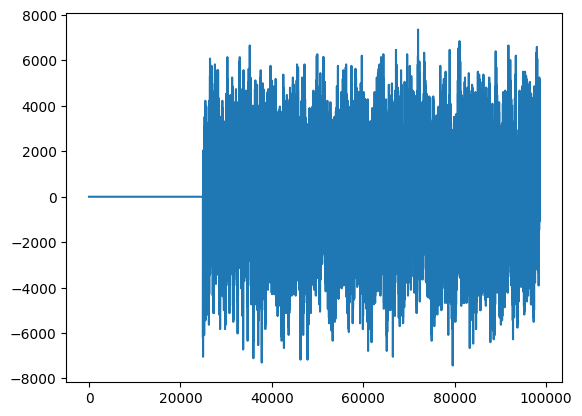

77753 2.5387830694635576


In [95]:
wavsize = 0
compressed_size = 0
with zipfile.ZipFile('data.zip') as archive:
    for name in archive.namelist()[1:2]:
        if not name.endswith('.wav'):
            continue
        with archive.open(name) as file:
            wav = scipy.io.wavfile.read(io.BytesIO(file.read()))[1]
            wavsize += len(wav) * 16
        
            initial_state = 0

            counts = Counter(wav)
            wav_values = list(counts.keys())
            alphabet = list(range(len(wav_values)))
            pmf = [counts[v]/len(wav) for v in wav_values]
            entropy = sum(p*log2(1/p) for p in pmf)

            precision = 2 ** 16

            # For pmf=[1/2, 1/4, 1/4] at precision=8, the quantized cdf=[0, 4, 6, 8]
            cdf = reduce(lambda acc,el: acc + [acc[-1] + round(el*precision)], pmf, [0])

            # ANS requires these 2 functions.
            def cdf_func(symbol):
                ''' Function signature is symbol -> (cdf_low, cdf_high).
                This can be substituted for a more complex model like a neural network'''
                if symbol < 0 or symbol >= len(alphabet):
                    print(symbol)
                return cdf[symbol], cdf[symbol+1]

            def icdf_func(cdf_value):
                ''' Function signature is cdf_value -> (symbol, cdf_low, cdf_high).
                Finds the symbol where cdf_func(symbol) <= cdf_value < cdf_func(symbol+1)
                This can be substituted for a more complex model like a neural network'''
                for symbol in alphabet:
                    cdf_low, cdf_high = cdf_func(symbol)
                    if cdf_low <= cdf_value < cdf_high:
                        return symbol, cdf_low, cdf_high

            # Some symbols to compress
            sequence = [wav_values.index(v) for v in wav]

            # Encode
            state = initial_state
            for symbol in reversed(sequence):
                state = push(state, symbol, cdf_func, precision)

            compressed_size += state.bit_length()
            rate = state.bit_length()/len(sequence)

            # Decode
            decoded_sequence = len(sequence)*[0]
            for i in range(len(sequence)):
                decoded_sequence[i], state = pop(state, icdf_func, cdf_func, precision)

            # Sanity checks
            plt.plot(wav - [wav_values[s] for s in decoded_sequence])
            plt.show()
            # assert decoded_sequence == sequence
            # assert (rate - entropy) < 0.01


byts = int(np.ceil(compressed_size / 8))
wavsize = int(np.ceil(wavsize / 8))
print(byts, wavsize / byts)

# Huffman coding with diff

In [29]:
from dahuffman import HuffmanCodec

wavsize = 0
compressed_size = 0
with zipfile.ZipFile('data.zip') as archive:
    for name in archive.namelist():
        if not name.endswith('.wav'):
            continue
        with archive.open(name) as file:
            wav = scipy.io.wavfile.read(io.BytesIO(file.read()))[1]
            wavsize += len(wav) * 16
        
            deltas = np.diff(wav, 1).astype(np.int32)

            # huffman encoding
            codec = HuffmanCodec.from_data(deltas)
            encoded = codec.encode(deltas)

            compressed_size += 48 + len(encoded) * 8 + len(codec.get_code_table()) * 17

byts = int(np.ceil(compressed_size / 8))
wavsize = int(np.ceil(wavsize / 8))
print(byts, wavsize, wavsize / byts)

69621 197398 2.8353226756294796
